In [157]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
import theano
import numpy as np
import time
import skimage.io

import sys
sys.path.insert(0, '/home/flipvanrijn/Workspace/Dedicon-Thesis/')

In [135]:
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(precision=5, suppress=True)

# Settings
EMBEDDING_SIZE = 600

In [136]:
from networks.keras.vocab import Vocab

t_b = time.time()
vocab = Vocab('/home/flipvanrijn/Workspace/Dedicon-Thesis/downloads/coco_train_dataset.json')
print 'Vocabulary loaded in {}s'.format(time.time() - t_b)

Vocabulary loaded in 25.7355358601s


###Preprocessing###

 * __selective_search.py__ generates 2000+ bounding boxes based on colour and texture
 * __frcnn.py__ selects the N (19) best regions from the selective search set

Searching boxes |################################| 1/1
Writing to file /media/Data/flipvanrijn/datasets/coco/images/train/COCO_train2014_000000508955.jpg_boxes.mat...


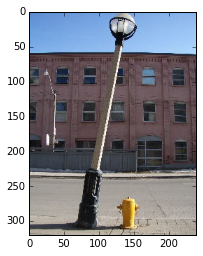

In [174]:
vocab_img_idx = 1234
img = vocab.images[vocab_img_idx]
plt.imshow(skimage.io.imread('/media/Data/flipvanrijn/datasets/coco/images/train/{}'.format(img)))
!python2.7 /home/flipvanrijn/Workspace/Dedicon-Thesis/selective_search.py --image=/media/Data/flipvanrijn/datasets/coco/images/train/$img

In [175]:
!python2.7 /home/flipvanrijn/Workspace/Dedicon-Thesis/frcnn.py -i /media/Data/flipvanrijn/datasets/coco/images/train/$img -o=/home/flipvanrijn/Workspace/Dedicon-Thesis/output/`echo $img`.mat

I0727 16:23:24.244647 26432 net.cpp:42] Initializing net from parameters: 
name: "VGG_CNN_M_1024"
input: "data"
input: "rois"
state {
  phase: TEST
}
input_shape {
  dim: 1
  dim: 3
  dim: 224
  dim: 224
}
input_shape {
  dim: 1
  dim: 5
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  param {
    lr_mult: 0
    decay_mult: 0
  }
  param {
    lr_mult: 0
    decay_mult: 0
  }
  convolution_param {
    num_output: 96
    kernel_size: 7
    stride: 2
  }
}
layer {
  name: "relu1"
  type: "ReLU"
  bottom: "conv1"
  top: "conv1"
}
layer {
  name: "norm1"
  type: "LRN"
  bottom: "conv1"
  top: "norm1"
  lrn_param {
    local_size: 5
    alpha: 0.0005
    beta: 0.75
    k: 2
  }
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "norm1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 3
    stride: 2
  }
}
layer {
  name: "conv2"
  type: "Convolution"
  bottom: "pool1"
  top: "conv2"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
 

###Experimenting with embedding image regions###

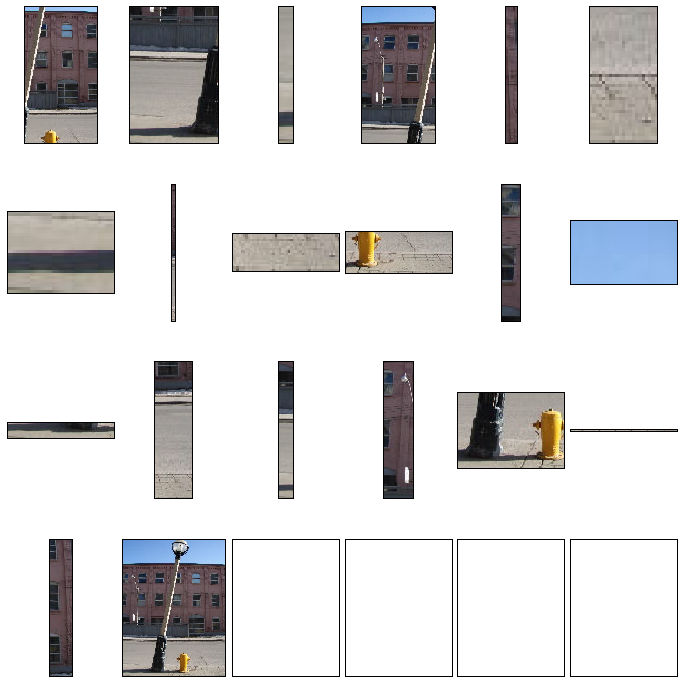

In [176]:
# Load image
import hdf5storage
image_data = hdf5storage.read(path='/', filename='/home/flipvanrijn/Workspace/Dedicon-Thesis/output/{}.mat'.format(img))
image_feats = image_data[0][0][0][0].astype(np.float32) # 4096 features from CNN
image_fragments = image_data[0][0][0][1]                # regions in image

# Lets visualize
fig_r, axes_r = plt.subplots(4, 6, figsize=(12, 12), subplot_kw={'xticks': [], 'yticks': []})
fig_r.subplots_adjust(hspace=0.3, wspace=0.05)
for ax, roi in zip(axes_r.flat, image_fragments):
    ax.imshow(roi, interpolation='nearest', aspect='equal')

In [177]:
image_model = Sequential()
image_model.add(Dense(4096, EMBEDDING_SIZE, init='uniform', activity_regularizer=l2(1e-3)))
f_image = theano.function([image_model.get_input(train=False)], image_model.get_output(train=False))
img_output = f_image(image_feats) # CNN input w/ shape (nb_regions, nb_features)

(4096, 600) (600,)


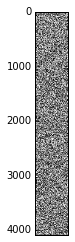

In [160]:
print image_model.layers[0].W.get_value().shape, image_model.layers[0].b.get_value().shape
fig, ax = plt.subplots()
ax.xaxis.set_visible(False)
ax.imshow(image_model.layers[0].W.get_value())

###Experimenting with embedding sentence###

In [181]:
# Load a sentence
sentence = vocab.sentences[vocab.img_to_sent[vocab_img_idx][0]]
sentence_1h = np.array(vocab.sentence_to_1h(sentence))
sentence_1h = sentence_1h[:, np.newaxis, :]
print sentence
print sentence_1h

[u'a', u'street', u'light', u'slightly', u'leaning', u'to', u'the', u'right', u'.']
[[[ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]]

 ..., 
 [[ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]]]


In [164]:
from networks.keras.birnn import BiDirectionLSTM
t_b = time.time()
sent_model = Sequential()
sent_model.add(BiDirectionLSTM(8856, EMBEDDING_SIZE, activation='relu', output_mode='sum', inner_activation='relu'))
f_sent = theano.function([sent_model.get_input(train=False)], sent_model.get_output(train=False))
print 'Compiled BiRNN in {}s'.format(time.time() - t_b)

Compiled BiRNN in 16.4489610195s


In [186]:
t_b = time.time()
sentence_1h.shape
sent_output = f_sent(sentence_1h)
print sent_output
print 'Sentence embedding in {}: {}'.format(time.time() - t_b, sent_output.shape)

[[[ 0.       0.       0.      ...,  0.       0.00001  0.     ]]

 [[ 0.       0.       0.      ...,  0.       0.00001  0.     ]]

 [[ 0.       0.       0.      ...,  0.       0.       0.     ]]

 ..., 
 [[ 0.       0.       0.      ...,  0.       0.       0.     ]]

 [[ 0.       0.       0.      ...,  0.       0.       0.     ]]

 [[ 0.       0.       0.00001 ...,  0.       0.       0.     ]]]
Sentence embedding in 0.0125689506531: (9, 1, 600)


###No training: v<sub>i</sub>*s<sub>t</sub>###

S_kl = 0.183578938246


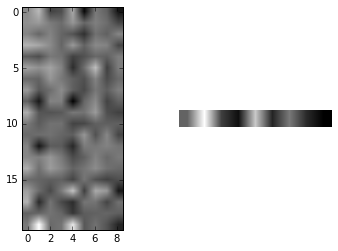

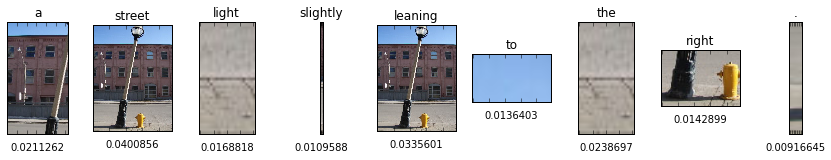

In [184]:
# Compute the word/image scores
nb_img_fragments = img_output.shape[0]
nb_sent_fragments = sent_output.shape[0]
scores = np.empty((nb_img_fragments, nb_sent_fragments), dtype=np.float32)
for t in xrange(nb_sent_fragments):
    for i in xrange(nb_img_fragments):
        fragment_out = img_output[i]
        sent = sent_output[t]
        scores[i][t] = np.dot(fragment_out, np.squeeze(sent))
max_scores = np.amax(scores, axis=0)[np.newaxis, :]
plt.gray()
fig_feats, ax_feats = plt.subplots(1, 2)
ax_feats[0].imshow(scores)
ax_feats[1].imshow(max_scores)
ax_feats[1].axis('off')
idx_fragment = np.argmax(scores, axis=0)
print 'S_kl = {}'.format(np.sum(max_scores))

# Plot the images with their words
fig_fragments, ax_fragments = plt.subplots(1, len(idx_fragment))
fig_fragments.set_size_inches(15, 2)
for i, idx in enumerate(idx_fragment):
    ax_fragments[i].imshow(image_fragments[idx])
    ax_fragments[i].yaxis.set_visible(False)
    ax_fragments[i].set_title(sentence[i])
    ax_fragments[i].set_xticklabels([])
    ax_fragments[i].set_xlabel(max_scores[0][i])